In [46]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

# Task 1


In [47]:
customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")

In [48]:
print(customers.head())
print(products.head())
print(transactions.head())


  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3       

In [49]:
print(customers.describe())
print(products.describe())
print(transactions.describe())

       CustomerID      CustomerName         Region  SignupDate
count         200               200            200         200
unique        200               200              4         179
top         C0001  Lawrence Carroll  South America  2024-11-11
freq            1                 1             59           3
            Price
count  100.000000
mean   267.551700
std    143.219383
min     16.080000
25%    147.767500
50%    292.875000
75%    397.090000
max    497.760000
          Quantity   TotalValue       Price
count  1000.000000  1000.000000  1000.00000
mean      2.537000   689.995560   272.55407
std       1.117981   493.144478   140.73639
min       1.000000    16.080000    16.08000
25%       2.000000   295.295000   147.95000
50%       3.000000   588.880000   299.93000
75%       4.000000  1011.660000   404.40000
max       4.000000  1991.040000   497.76000


In [50]:
merged_data = pd.merge(transactions, products, on="ProductID")
merged_data = pd.merge(merged_data, customers, on="CustomerID")

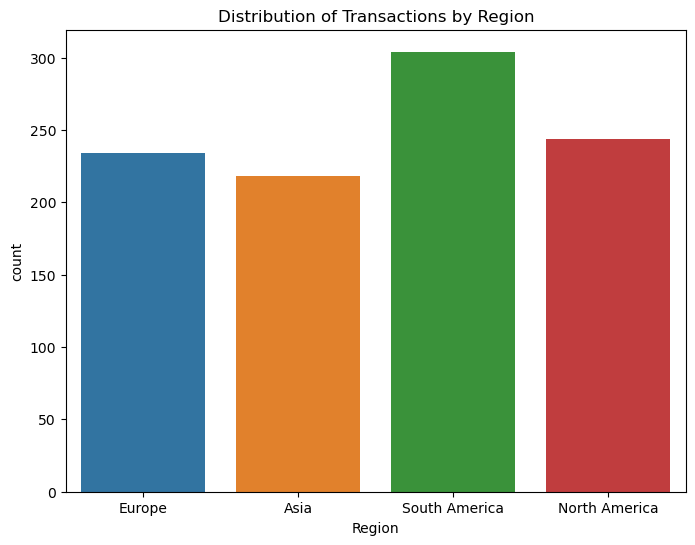

In [51]:
plt.figure(figsize=(8, 6))
sns.countplot(x="Region", data=merged_data)
plt.title("Distribution of Transactions by Region")
plt.show()

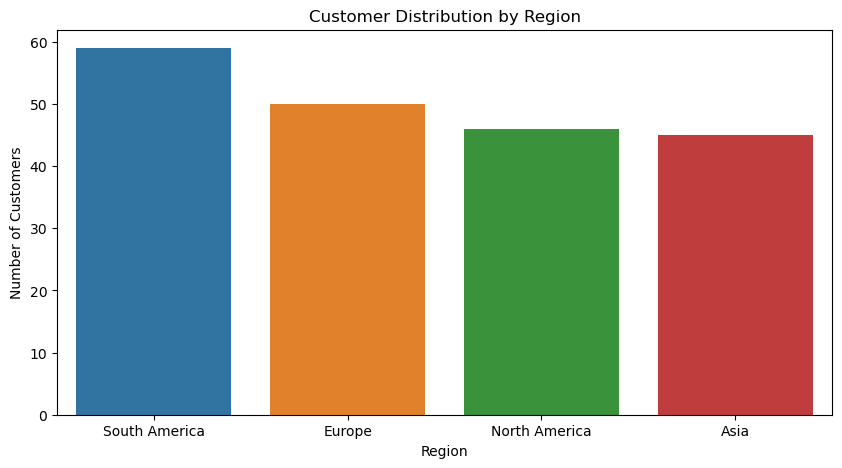

In [52]:
region_counts = customers['Region'].value_counts()
plt.figure(figsize=(10, 5))
sns.barplot(x=region_counts.index, y=region_counts.values)
plt.title('Customer Distribution by Region')
plt.xlabel('Region')
plt.ylabel('Number of Customers')
plt.show()

In [53]:
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])
transactions['Year'] = transactions['TransactionDate'].dt.year
transactions['Month'] = transactions['TransactionDate'].dt.month

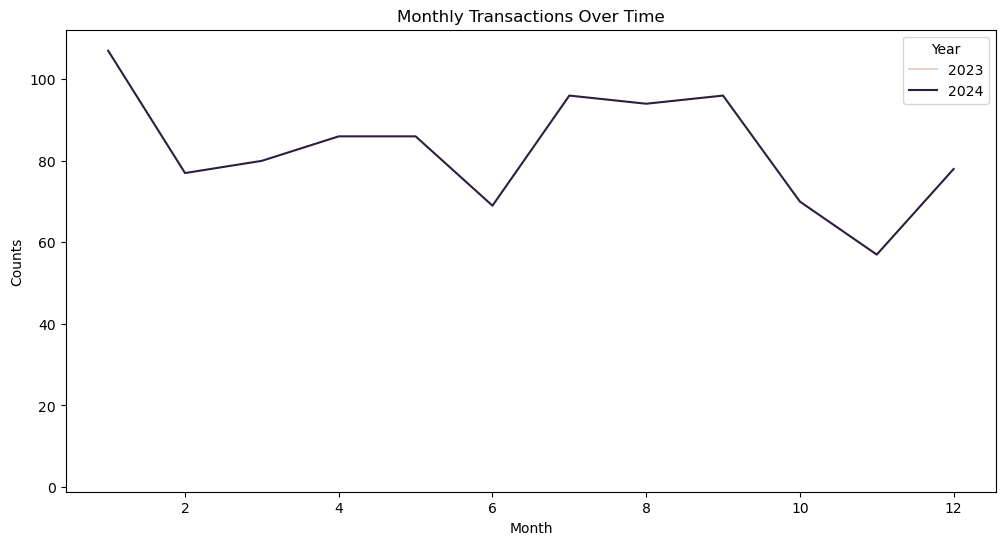

In [54]:
monthly_transactions = transactions.groupby(['Year', 'Month']).size().reset_index(name='Counts')
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_transactions, x='Month', y='Counts', hue='Year')
plt.title('Monthly Transactions Over Time')
plt.show()

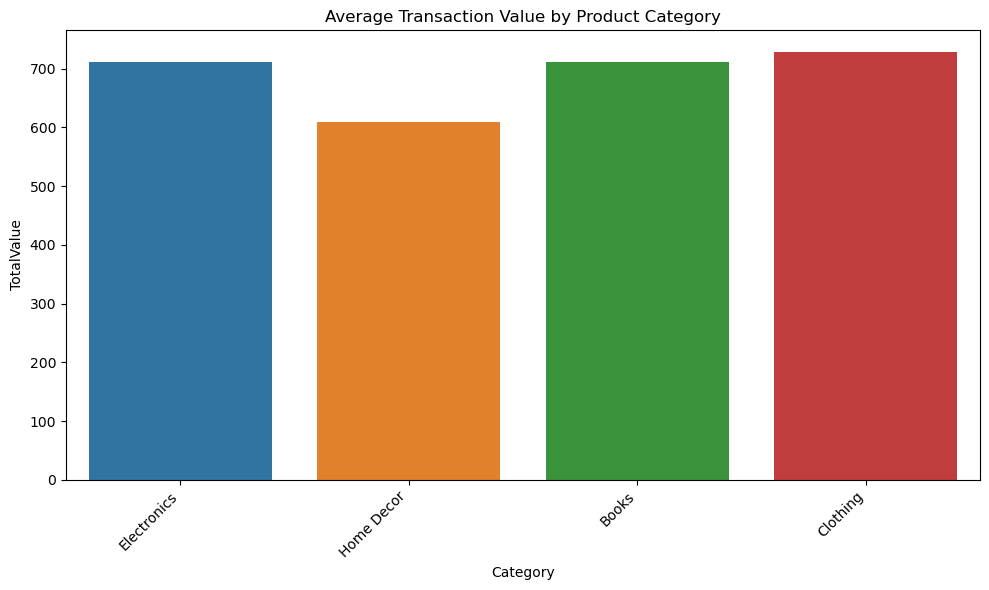

In [55]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Category", y="TotalValue", data=merged_data, errorbar=None)
plt.title("Average Transaction Value by Product Category")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [56]:
top_products = transactions.groupby('ProductID')['TotalValue'].sum().nlargest(5).reset_index()
top_products = top_products.merge(products[['ProductID', 'ProductName']], on='ProductID')
print(top_products)


  ProductID  TotalValue         ProductName
0      P029    19513.80  TechPro Headphones
1      P079    17946.91      ActiveWear Rug
2      P048    17905.20    TechPro Cookbook
3      P020    15060.92   ActiveWear Jacket
4      P062    14592.24     HomeSense Novel


In [57]:
customer_transactions = transactions.merge(customers, on='CustomerID')
customer_summary = customer_transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'SignupDate': 'first'
}).reset_index()

#  Task 2

In [58]:
customer_summary['SignupDate'] = pd.to_datetime(customer_summary['SignupDate'])
customer_summary['SignupYear'] = customer_summary['SignupDate'].dt.year
customer_summary['TotalValue'] = StandardScaler().fit_transform(customer_summary[['TotalValue']])
customer_summary['Quantity'] = StandardScaler().fit_transform(customer_summary[['Quantity']])

In [59]:
similarity_matrix = cosine_similarity(customer_summary[['TotalValue', 'Quantity']])
similarity_df = pd.DataFrame(similarity_matrix, index=customer_summary['CustomerID'], columns=customer_summary['CustomerID'])

In [60]:
lookalike_results = {}
for cust_id in customer_summary['CustomerID'][:20]:
    similar_customers = similarity_df[cust_id].nlargest(4).iloc[1:]
    lookalike_results[cust_id] = similar_customers.index.tolist(), similar_customers.values.tolist()

In [61]:
lookalike_df = pd.DataFrame.from_dict(lookalike_results, orient='index', columns=['SimilarCustomers', 'Scores'])
lookalike_df.to_csv('Lookalike.csv')

# Task 3


In [62]:
customer_transaction_data = pd.merge(customers, transactions, on='CustomerID', how='left')
customer_transaction_data = pd.merge(customer_transaction_data, products, on='ProductID', how='left')
customer_summary = customer_transaction_data.groupby('CustomerID').agg(
    TotalSpending=('TotalValue', 'sum'),
    NumberOfTransactions=('TransactionID', 'count')
).reset_index()


In [63]:
customer_profile = pd.merge(customers, customer_summary, on='CustomerID', how='left')

In [64]:
customer_profile = pd.get_dummies(customer_profile, columns=['Region'])

In [65]:
numerical_cols_cluster = ['TotalSpending', 'NumberOfTransactions']  # Add other relevant numerical columns
customer_profile[numerical_cols_cluster] = scaler.fit_transform(customer_profile[numerical_cols_cluster])


In [66]:
n_clusters = 3 
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
customer_profile['Cluster'] = kmeans.fit_predict(customer_profile.drop(['CustomerID', 'CustomerName', 'SignupDate'], axis=1))


In [67]:
db_index = davies_bouldin_score(customer_profile[numerical_cols_cluster], customer_profile['Cluster'])

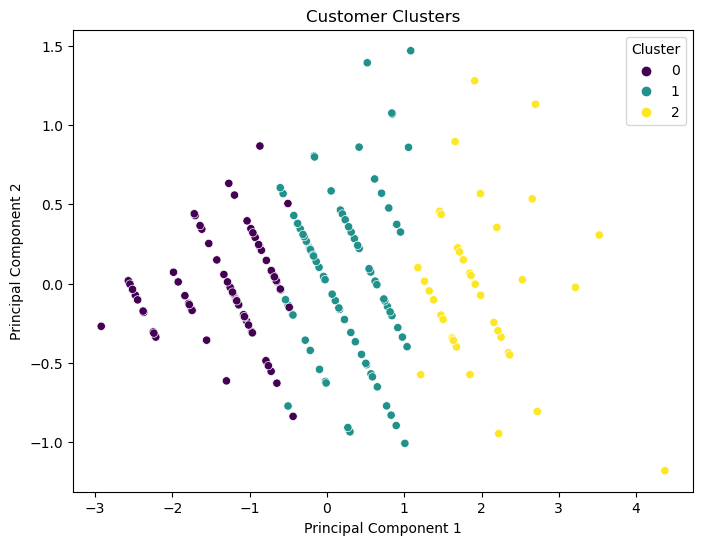

In [68]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(customer_profile[numerical_cols_cluster])
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=customer_profile['Cluster'], palette='viridis')
plt.title("Customer Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [69]:
print(f"Number of Clusters: {n_clusters}")
print(f"DB Index: {db_index}")

Number of Clusters: 3
DB Index: 0.775109678286262
